# Explore Data Analysis

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")                                                      


In [3]:
df = pd.read_csv('aemo_wu_merged.csv', index_col = 0)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),Condition
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,Fair
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,Fair
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,Fair
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,Fair
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,Fair


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97504 entries, 0 to 97503
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                97504 non-null  object 
 1   Operational Demand (MW)  97504 non-null  float64
 2   temperature(celcius)     97504 non-null  float64
 3   dew_point(celcius)       97504 non-null  float64
 4   humidity(%)              97504 non-null  float64
 5   Wind                     97504 non-null  object 
 6   wind_speed(mph)          97504 non-null  float64
 7   wind_gush(mph)           97504 non-null  float64
 8   pressure(in)             97504 non-null  float64
 9   precip.(in)              97504 non-null  float64
 10  Condition                97504 non-null  object 
dtypes: float64(8), object(3)
memory usage: 8.9+ MB


Except the 'Operational Demand (MW)', which is the main variable that needed to be predicted, and time, there are 9 factors in total, whithin which, there are 7 numeric type.

In [5]:
df.describe()

,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),wind_speed(mph),wind_gush(mph),pressure(in),precip.(in)
count,97504.000000,97504.000000,97504.000000,97504.000000,97504.000000,97504.000000,97504.000000,97504.0
mean,2024.033428,19.192862,10.358651,61.199264,11.037301,0.911634,29.332540,0.0
std,403.227198,6.504368,4.280321,21.330864,5.149548,5.521146,0.471126,0.0
min,761.204000,1.100000,-15.000000,5.000000,0.000000,0.000000,29.000000,0.0
25%,1739.725500,13.900000,7.200000,47.000000,7.000000,0.000000,29.000000,0.0
50%,1949.919000,18.900000,10.000000,58.000000,10.000000,0.000000,29.000000,0.0
75%,2260.464000,23.900000,13.900000,77.000000,14.000000,0.000000,30.000000,0.0
max,3979.836000,42.800000,22.800000,100.000000,37.000000,58.000000,30.000000,0.0


For the 7 numeric factors, it is obviously that the 'precip.(in)' always displays 0 in most of time which means it can be directly ignored in the subsequent procession. For 'wind_gush' and 'pressure', it seems that they show a kind of polarization.

In [6]:
# Seperate timestamp and set several new variables
def wind_ans(x):
    if x > 0: 
        return "Wind" 
    else:
        return 'No Wind'
df[['Date','Trading Interval Time']] = df['timestamp'].str.split(" ",expand=True)  # split time into date and interval timedf['Date'] = pd.to_datetime(df['Date'])
# df['year'] = df['Date'].dt.year
# df['month'] = df['Date'].dt.month
# df['day'] = df['Date'].dt.day
df['Date'] = pd.to_datetime(df['Date'])
df['new_timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['new_timestamp'].dt.year
df['month'] = df['new_timestamp'].dt.month
df['day'] = df['new_timestamp'].dt.day
df['hour'] = df['new_timestamp'].dt.hour
df['minute'] = df['new_timestamp'].dt.minute
df['has_Wind'] = df['wind_speed(mph)'].apply(wind_ans) 
df.describe()

,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),year,month,day,hour,minute
count,97504.000000,97504.000000,97504.000000,97504.000000,97504.000000,97504.000000,97504.000000,97504.0,97504.000000,97504.000000,97504.000000,97504.000000,97504.000000
mean,2024.033428,19.192862,10.358651,61.199264,11.037301,0.911634,29.332540,0.0,2019.355432,6.329669,15.712832,11.498687,15.000000
std,403.227198,6.504368,4.280321,21.330864,5.149548,5.521146,0.471126,0.0,1.622490,3.380367,8.808694,6.922475,15.000077
min,761.204000,1.100000,-15.000000,5.000000,0.000000,0.000000,29.000000,0.0,2017.000000,1.000000,1.000000,0.000000,0.000000
25%,1739.725500,13.900000,7.200000,47.000000,7.000000,0.000000,29.000000,0.0,2018.000000,3.000000,8.000000,5.000000,0.000000
50%,1949.919000,18.900000,10.000000,58.000000,10.000000,0.000000,29.000000,0.0,2019.000000,6.000000,16.000000,11.000000,15.000000
75%,2260.464000,23.900000,13.900000,77.000000,14.000000,0.000000,30.000000,0.0,2021.000000,9.000000,23.000000,17.000000,30.000000
max,3979.836000,42.800000,22.800000,100.000000,37.000000,58.000000,30.000000,0.0,2022.000000,12.000000,31.000000,23.000000,30.000000


## Correlation hotmap

In [7]:
corr = df.corr()
corr

,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),year,month,day,hour,minute
Operational Demand (MW),1.000000,0.196843,0.121277,-0.067923,0.044680,-0.018715,-0.095511,NaN,1.767428e-02,-1.597865e-01,-1.384855e-02,4.500611e-01,-2.128365e-03
temperature(celcius),0.196843,1.000000,0.307910,-0.771656,0.397263,-0.010542,-0.468408,NaN,1.798175e-01,-2.296745e-01,2.862851e-05,2.313580e-01,-1.103755e-04
dew_point(celcius),0.121277,0.307910,1.000000,0.304610,0.035015,-0.039337,-0.446545,NaN,2.077197e-01,-2.364257e-01,1.028890e-02,5.789315e-02,3.606118e-04
humidity(%),-0.067923,-0.771656,0.304610,1.000000,-0.439327,-0.027854,0.163130,NaN,-6.982877e-02,7.979314e-02,9.842478e-03,-2.064445e-01,3.437775e-04
wind_speed(mph),0.044680,0.397263,0.035015,-0.439327,1.000000,0.325810,-0.293212,NaN,8.609661e-02,-3.889776e-02,-1.268889e-02,1.058549e-01,-1.005778e-03
wind_gush(mph),-0.018715,-0.010542,-0.039337,-0.027854,0.325810,1.000000,-0.067798,NaN,-1.126201e-02,3.940341e-03,-1.727431e-02,-3.004143e-02,7.274335e-03
pressure(in),-0.095511,-0.468408,-0.446545,0.163130,-0.293212,-0.067798,1.000000,NaN,-1.514338e-01,1.011638e-01,-1.122454e-02,-1.222809e-02,7.401536e-04
precip.(in),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,0.017674,0.179818,0.207720,-0.069829,0.086097,-0.011262,-0.151434,NaN,1.000000e+00,-1.459498e-01,-1.941559e-02,-3.091031e-04,4.924740e-17
month,-0.159787,-0.229675,-0.236426,0.079793,-0.038898,0.003940,0.101164,NaN,-1.459498e-01,1.000000e+00,-5.846022e-04,-9.370644e-05,1.868350e-20


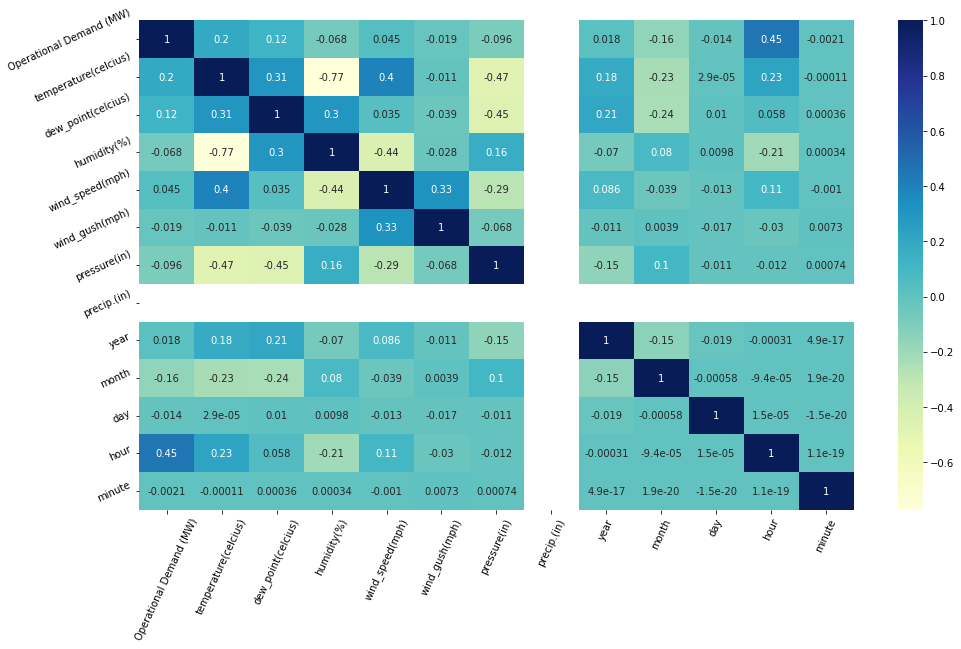

In [8]:
plt.figure(figsize=(16, 9))
ax = sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.xticks(rotation=65)
plt.yticks(rotation=25)
plt.show()

From the hotmap of correlations, confimed that ‘precip.(in)' has no relation with predict variable, even the other factors.

For factors that relation to 'operation demand', the 'temperature' has the highest correlation coefficient, while month is the second, which,in certain extent, supports our project that find the top 4 peak days in summer. 


In [9]:
pd.options.display.notebook_repr_html= False
plt.rcParams['figure.dpi']=75
sns.set_theme(style='darkgrid')

## Long Term

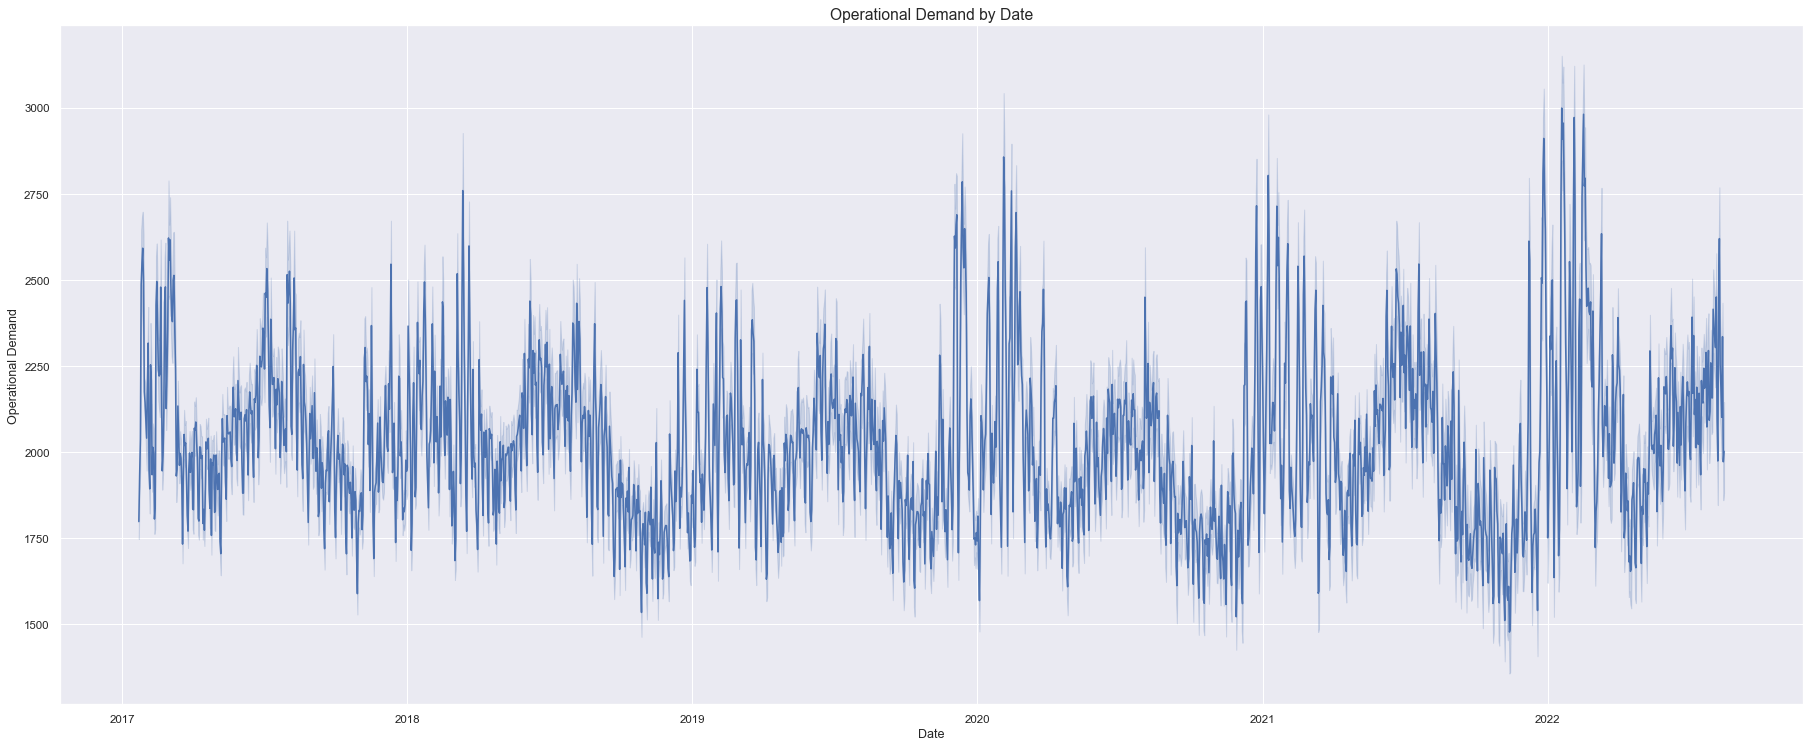

In [10]:
s=pd.DataFrame(dict(y=df['Operational Demand (MW)'],x=df['Date']))
plt.figure(figsize=(30,12))
sns.lineplot(data=s,x= 'x',y='y')
plt.xlabel('Date')
plt.ylabel('Operational Demand')
plt.title("Operational Demand by Date",fontsize = 15)
plt.show()

By date, there doesn't seem to be a significant pattern overall, but by year, the operational demand shows similar trend.At the begining, the middle and the end of each year, the demands reach peaks. Besides, for most of time, of the three peaks, at the begining of a year is the highest peak, and with time goes, this highest peak become higher and higher.

### per Month
To be more specific, we obtain the mean operational demand of each month and days

<AxesSubplot:title={'center':'Mean Operational Demand per Month'}, xlabel='month,day'>

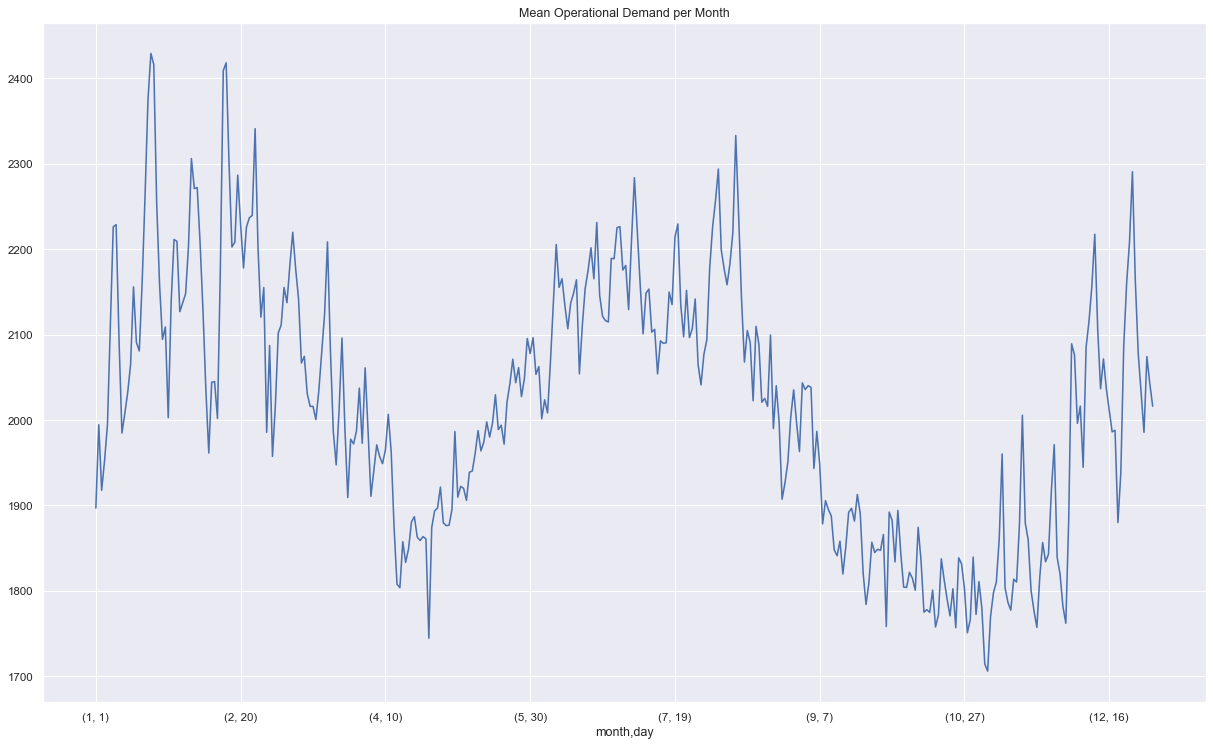

In [11]:
OD_mon_l=df.groupby([df["month"],df["day"]]).mean()['Operational Demand (MW)']
OD_mon_l.plot(title="Mean Operational Demand per Month",figsize=(20,12))

In this plot, we can see the demands more clearly in a year, which confirms that at the begining of a year, especially January and February, the demands are higher than the other months.

### per Day
Look at the data on a daily basis

<AxesSubplot:title={'center':'Mean Operational Demand per Day'}, xlabel='Trading Interval Time'>

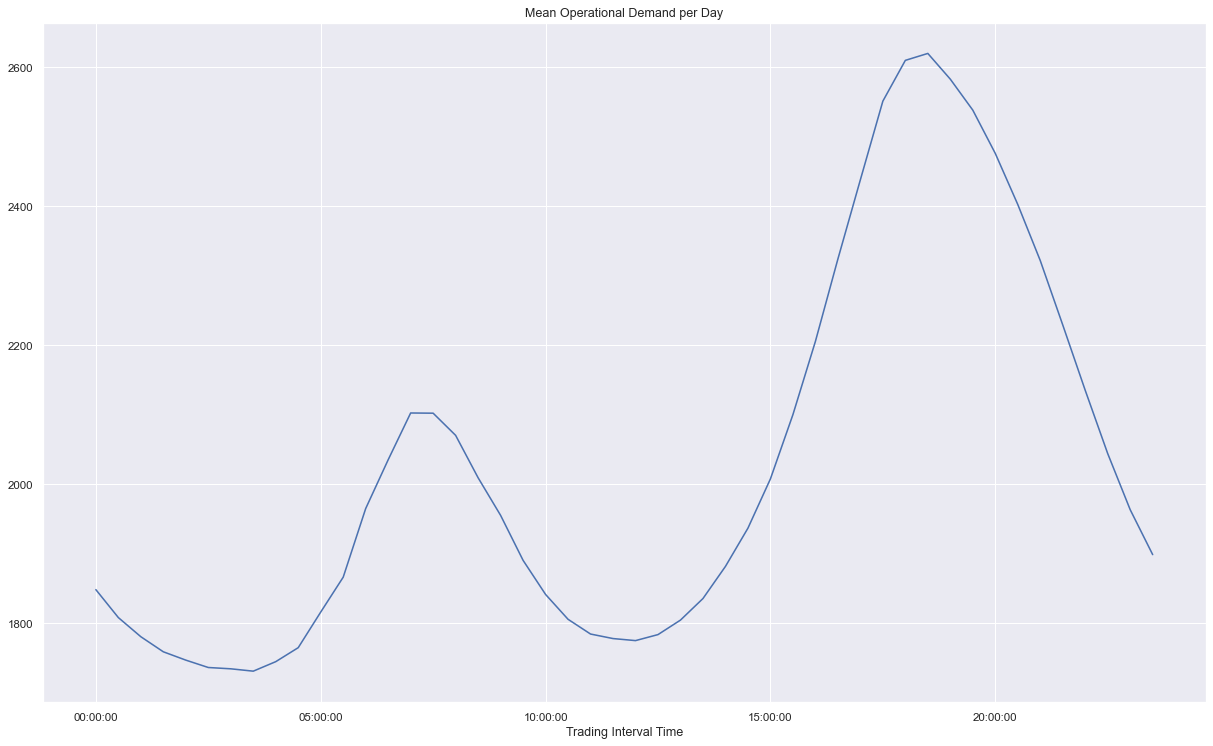

In [12]:
OD_day_l=df.groupby('Trading Interval Time').mean()['Operational Demand (MW)']
OD_day_l.plot(title="Mean Operational Demand per Day",figsize=(20,12))

In one day, the mean demand reach the highest aroung 6 to 7 p.m. and the lowest happened around 4 a.m.

## Short Term from Dec to Mar

<AxesSubplot:title={'center':'Mean Operational Demand per Month'}, xlabel='year,month,day'>

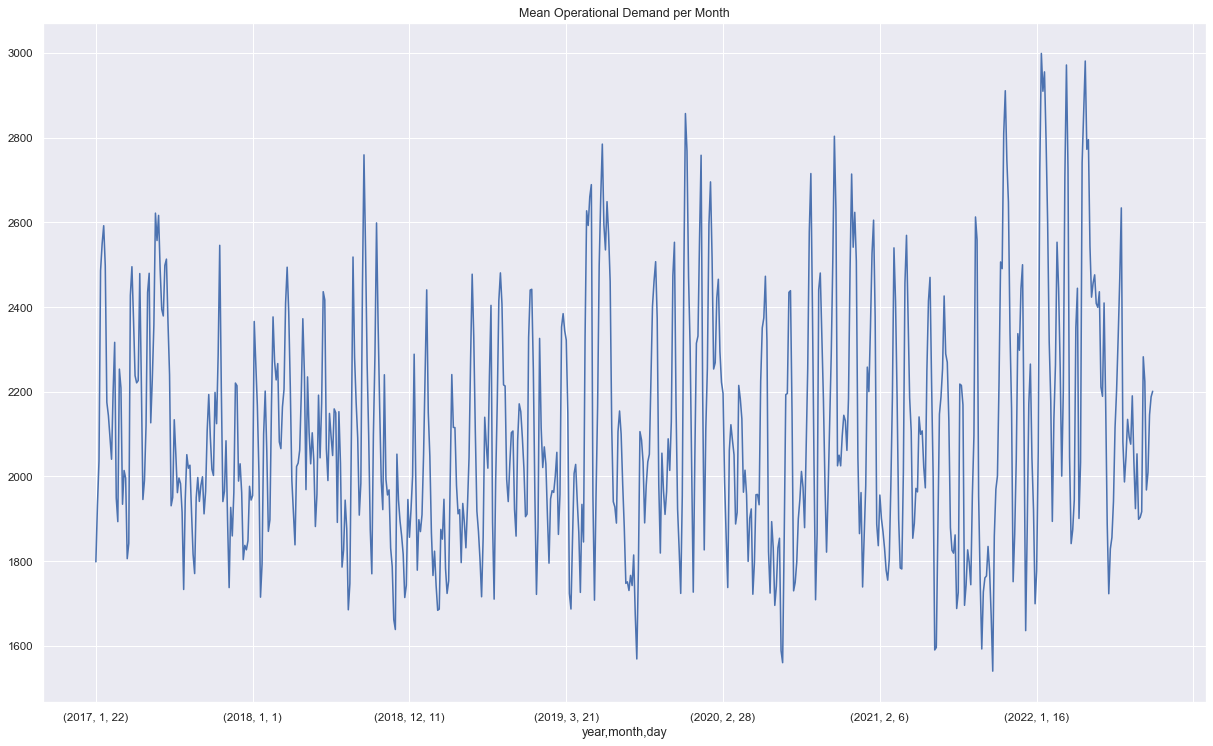

In [10]:
df_s = df[(df['month'] ==12 )|(df['month'] < 4)]
OD_mon_s=df_s.groupby([df_s["year"],df_s["month"],df_s["day"]]).mean()['Operational Demand (MW)']
OD_mon_s.plot(title="Mean Operational Demand per Month",figsize=(20,12)) 


January and February take the position of higher demands， while at the begining of December is the lowest.

## Facotrs

In [14]:
# Numeric factors
numeric = []
for i in df.columns:
    if df[i].dtype == 'float64':
        if i == 'Operational Demand (MW)':
            pass
        else:
            numeric.append(i)
numeric

['temperature(celcius)',
 'dew_point(celcius)',
 'humidity(%)',
 'wind_speed(mph)',
 'wind_gush(mph)',
 'pressure(in)',
 'precip.(in)']

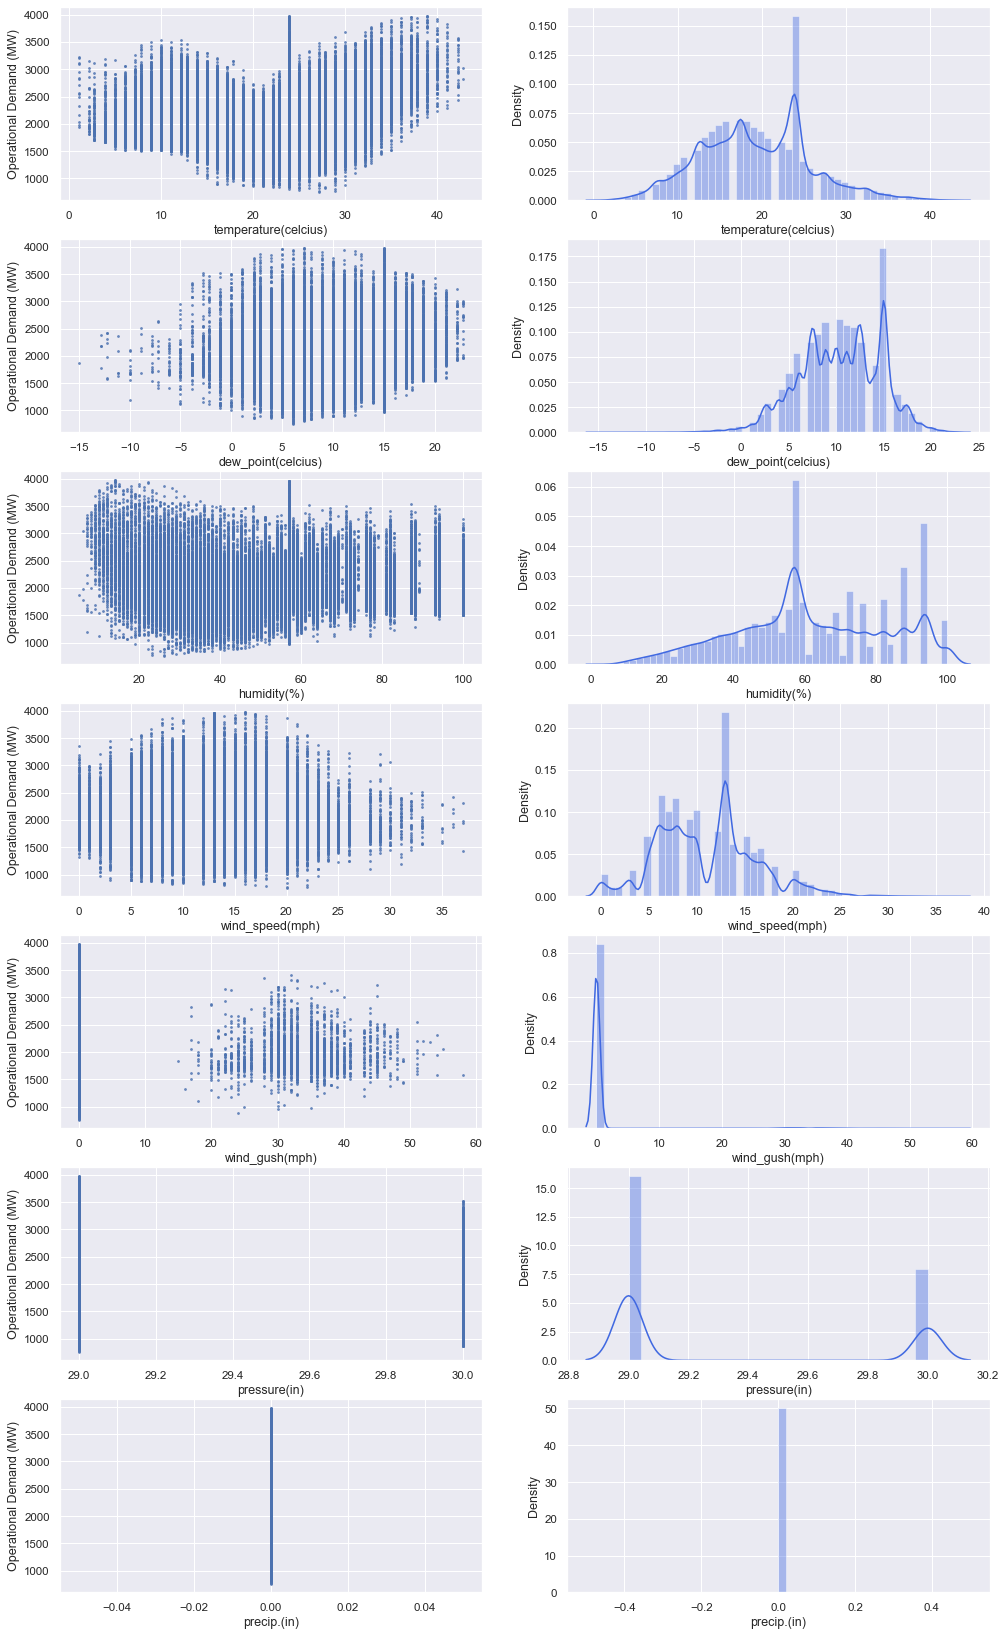

In [15]:
fig, ax = plt.subplots(len(numeric), 2, figsize=(16, len(numeric) * 4))

for n in range(len(numeric)):
    feat = numeric[n]
    ax[n, 0].scatter(df[feat].values, df['Operational Demand (MW)'].values, s=3, alpha = 0.7)
    ax[n, 0].set_ylabel("Operational Demand (MW)")
    ax[n, 0].set_xlabel(feat)

    # Distribution
    sns.distplot(df[feat].dropna(), ax=ax[n, 1], color="royalblue")

For the scatter plots above, 'temperature','dew point','humidity', 'wind speed' and 'pressure' seem have relations with 'operation demand', however, in the plots of distribution of each variables, except 'pressure', the others have more scattered data, thus we can focus on these four types.

### Monthly Trend (temp,humid,wind_speed,dew_point)

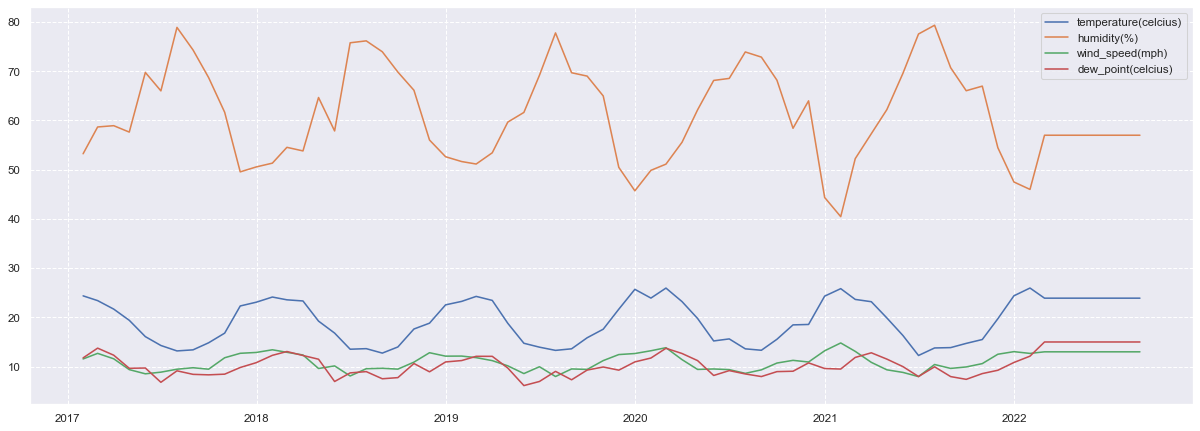

In [16]:
df.set_index('Date', inplace = True)
sub_m_df = df.resample('M')['temperature(celcius)','humidity(%)','wind_speed(mph)','dew_point(celcius)'].mean()
plt.figure(figsize = (20,7))
plt.plot(sub_m_df.index,sub_m_df["temperature(celcius)"], label = "temperature(celcius)")
plt.plot(sub_m_df.index,sub_m_df["humidity(%)"], label = "humidity(%)")
plt.plot(sub_m_df.index,sub_m_df["wind_speed(mph)"], label = "wind_speed(mph)")
plt.plot(sub_m_df.index,sub_m_df["dew_point(celcius)"], label = "dew_point(celcius)")
# plt.plot(sub_m_df.index,sub_m_df["Operational Demand (MW)"], label = "Operational Demand (MW)")
plt.grid(linestyle = "--")
plt.legend()

Follow by a line chart of the four variables, we can see that the trend of humidity is opposite to the others, and the value of it is clearly the highest among the 4 variables. As to wind speed and dew point, they mutual crisscross, about the same level. And for temperature, it is a little higher than wind speed and dew point.

### Weekly Trend (temp,humid,wind_speed,dew_point)

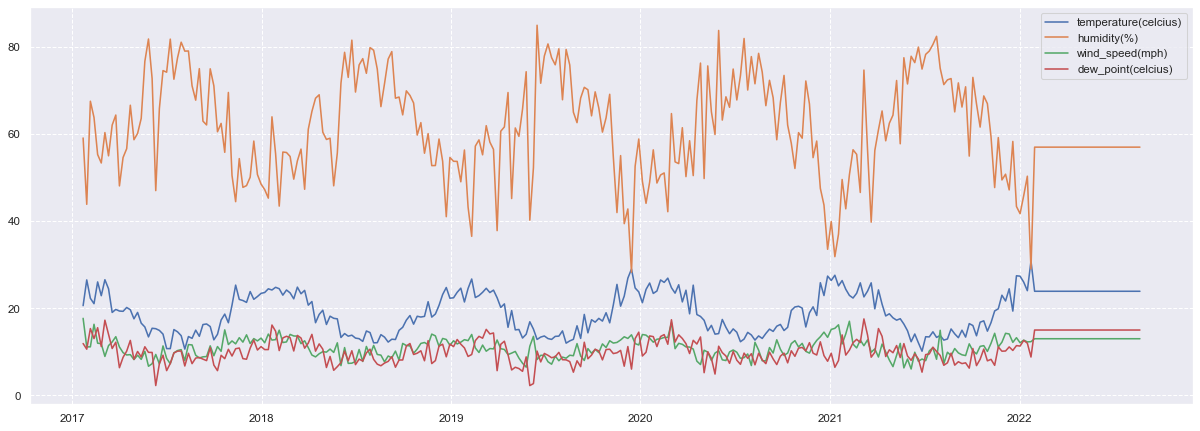

In [17]:
sub_w_df = df.resample('W')['temperature(celcius)','humidity(%)','wind_speed(mph)','dew_point(celcius)'].mean()
plt.figure(figsize = (20,7))
plt.plot(sub_w_df.index,sub_w_df["temperature(celcius)"], label = "temperature(celcius)")
plt.plot(sub_w_df.index,sub_w_df["humidity(%)"], label = "humidity(%)")
plt.plot(sub_w_df.index,sub_w_df["wind_speed(mph)"], label = "wind_speed(mph)")
plt.plot(sub_w_df.index,sub_w_df["dew_point(celcius)"], label = "dew_point(celcius)")
plt.grid(linestyle = "--")
plt.legend()

For weekly, it is similar to the month trend, only it looks a little more tortuous. The trend of three variables,except temperature, are similar to monthly, and for temperature, higher value and total opposite trend with the other three vaiables. 

### Boxplot for wind

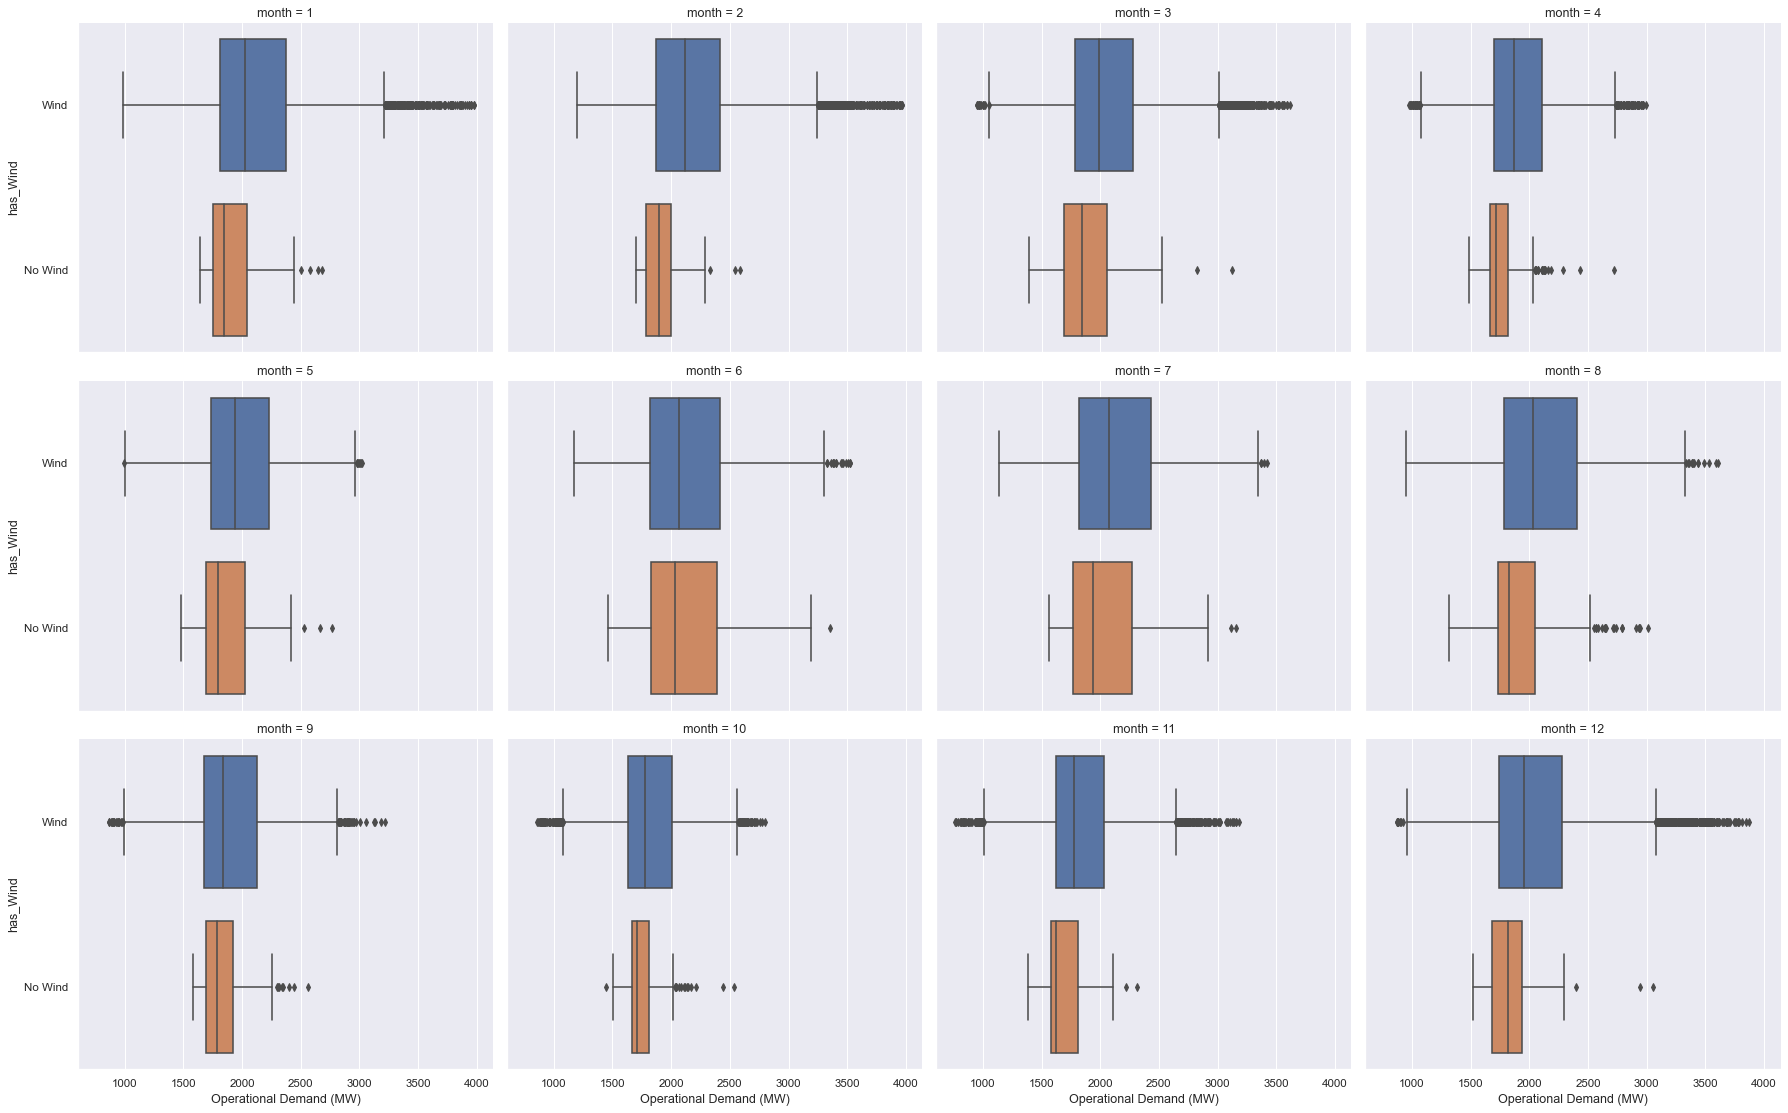

In [18]:
box_p = sns.catplot(kind = 'box', y= 'has_Wind', x = 'Operational Demand (MW)', data = df, col = 'month',
                orient="h", col_wrap= 4, aspect = 1.2)
box_p.set_xlabels("Operational Demand (MW)")

The number of windy days is higher than the number of windless days in each month, and we find that there are always a lot of outliers in the box of windy days, as to windless days, the outliers are not too much.

# Modelling

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from prettytable import PrettyTable


In [35]:
df.columns

Index(['timestamp', 'Operational Demand (MW)', 'temperature(celcius)',
       'dew_point(celcius)', 'humidity(%)', 'Wind', 'wind_speed(mph)',
       'wind_gush(mph)', 'pressure(in)', 'precip.(in)', 'Condition', 'Date',
       'Trading Interval Time', 'new_timestamp', 'year', 'month', 'day',
       'hour', 'minute', 'has_Wind'],
      dtype='object')

## Data Preparation

In [ ]:
def create_time_features(df_in):
    df = df_in
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['Year'] = df['timestamp'].dt.year
    df['Month'] = df['timestamp'].dt.month
    df['Hour'] = df['timestamp'].dt.hour
    df['Day_of_week'] = df['timestamp'].dt.dayofweek
    df['Day_of_month'] = df['timestamp'].dt.day
    df['Day_of_year'] = df['timestamp'].dt.dayofyear
    df.set_index('timestamp', inplace=True, drop=True)
    # df = df.astype('int')
    df.reset_index(inplace=True)
    time_features_df = df
    return time_features_df

In [41]:
df_a = create_time_features(df)
df_a.columns

Index(['timestamp', 'Operational Demand (MW)', 'temperature(celcius)',
       'dew_point(celcius)', 'humidity(%)', 'Wind', 'wind_speed(mph)',
       'wind_gush(mph)', 'pressure(in)', 'precip.(in)', 'Condition', 'Date',
       'Trading Interval Time', 'new_timestamp', 'year', 'month', 'day',
       'hour', 'minute', 'has_Wind', 'Year', 'Month', 'Hour', 'Day_of_week',
       'Day_of_month', 'Day_of_year'],
      dtype='object')

In [36]:
select_col=['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)','year', 'month', 'day','hour', 'minute']
y_col=['Operational Demand (MW)']
x_col=['temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)','year', 'month', 'day','hour', 'minute']
model_df=df[select_col]
training_dat = model_df[model_df['year'] != 2022]
testing_dat = model_df[model_df['year'] == 2022]

X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = testing_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = testing_dat['Operational Demand (MW)']

## Function Preparation

In [37]:
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)

## Feature Scale

In [28]:
stdsc=StandardScaler()
X_train_sc = stdsc.fit_transform(X_train)
X_test_sc = stdsc.transform(X_test)

## Decision Tree

In [24]:
tree_reg = DecisionTreeRegressor(random_state=42)

param_grid_dtree = dict(
    max_depth =[15,20,25],
    min_samples_leaf=[50,100,150])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=1,return_train_score=True)
grid_dtree.fit(X_train_sc,y_train)
y_pred_tree = grid_dtree.predict(X_test_sc)
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ImportanceDisplay('grid_dtree')
print(grid_dtree.best_estimator_)
print(grid_dtree.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Mean absolute error =  257.4022
Mean squared error =  134415.815
Median absolute error =  170.645
explained variance error =  0.4962
R2 error =  0.4254
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
| temperature(celcius) | 0.248  |
|  dew_point(celcius)  | 0.0407 |
|     humidity(%)      | 0.0125 |
|   wind_speed(mph)    | 0.0043 |
|         year         | 0.0441 |
|        month         | 0.0809 |
|         day          | 0.011  |
|         hour         | 0.5549 |
|        minute        | 0.0036 |
+----------------------+--------+
DecisionTreeRegressor(max_depth=15, min_samples_leaf=50, random_state=42)
-208.7964565253698


## Random Forest

In [33]:
# rf_reg = RandomForestRegressor(n_estimators=10000)
grid_rf = RandomForestRegressor(n_estimators=100)
# param_grid_rf = dict(
#      n_estimators=[200,300,400,500])

# grid_rf=GridSearchCV(rf_reg, param_grid_rf, cv=3, scoring='neg_root_mean_squared_error',verbose=1,return_train_score=True)
grid_rf.fit(X_train_sc,y_train)
y_pred_rf = grid_rf.predict(X_test_sc)
rfscore=ModelScore(y_test,y_pred_rf)
rfscore
#ImportanceDisplay('grid_rf')
# print(grid_rf.best_estimator_)
# print(grid_rf.best_score_)


# rf_reg.fit(X_train, y_train)
# y_pred_reg = rf_reg.predict(X_test)
# rfscore=ModelScore(y_test,y_pred_reg)
# rfscore
# ImportanceDisplay('rf_reg')

Mean absolute error =  241.7483
Mean squared error =  115026.0832
Median absolute error =  167.9098
explained variance error =  0.5313
R2 error =  0.5083


In [27]:
dtree_reg=DecisionTreeRegressor(max_depth=15, min_samples_leaf=50, random_state=42)
rforest_reg = RandomForestRegressor(max_depth=15, min_samples_leaf=50,n_jobs=-1, random_state=42,n_estimators=500)
psvm_reg=SVR(kernel='rbf', C=10, epsilon=0.1)

voting_reg = VotingRegressor(
    estimators=[('dtr',dtree_reg),('rfr',rforest_reg),('svmr',psvm_reg)])
voting_reg.fit(X_train_sc,y_train)
y_pred_voting = voting_reg.predict(X_test_sc)
votingscore = ModelScore(y_test,y_pred_voting)
votingscore

Mean absolute error =  262.9876
Mean squared error =  133885.2615
Median absolute error =  180.6646
explained variance error =  0.4745
R2 error =  0.4277


In [13]:
import holidays
country_holidays = holidays.CountryHoliday('AU')
df_s['is_holiday'] = df_s['Date'].map(lambda a:1 if a in country_holidays else 0)

In [17]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [18]:
values = df_s.values
train = series_to_supervised(values, n_in=6)